In [1]:
#in this notebook, I also attempt to find how each STU filter can be represented as a linear combination of LDSs
#however, to do this we will fit many STUs to LDSs and then use the learned weights to represent the STU as a linear combination of LDSs

In [2]:
import sys
import os
sys.path.append(os.path.abspath("../../src"))

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional  as  F
import math
import numpy as np

device = torch.device("cuda"  if torch.cuda.is_available() else "cpu")

In [4]:
def nearest_power_of_two(x: int, round_up: bool = False) -> int:
    return (
        1 << math.floor(math.log2(x)) if not round_up else 1 << math.ceil(math.log2(x))
    )

def convolve(u: torch.Tensor, v: torch.Tensor, n: int, use_approx: bool = True) -> tuple[torch.Tensor, torch.Tensor]:
    # print(u.shape, v.shape)
    bsz, seq_len, d_in = u.shape

    sgn = torch.full((1, seq_len, 1), 1, device=u.device)
    sgn[:, 1::2] *= -1

    _, K = v.shape
    sgn = sgn.unsqueeze(-1)
    v = v.view(1, -1, K, 1, 1).to(torch.float32) # (bsz, seq_len, K, d_in, stack)
    u = u.view(bsz, -1, 1, d_in).expand(bsz, -1, K, d_in)

    v = torch.fft.rfft(v, n=n, dim=1)
    U = torch.stack([u, u * sgn], dim=-1).to(torch.float32)
    U = torch.fft.rfft(U, n=n, dim=1)
    U_conv = torch.fft.irfft(v * U, n=n, dim=1)[:, :seq_len]
    U_plus, U_minus = torch.unbind(U_conv, dim=-1)
    U_minus = U_minus * sgn

    return U_plus, U_minus

In [5]:
def get_hankel(seq_len: int, use_hankel_L: bool = False) -> np.ndarray:
    entries = np.arange(1, seq_len + 1, dtype=np.float64)
    i_plus_j = entries[:, None] + entries[None, :]

    if use_hankel_L:
        sgn = (-1.0) ** (i_plus_j - 2.0) + 1.0
        denom = (i_plus_j + 3.0) * (i_plus_j - 1.0) * (i_plus_j + 1.0)
        Z = sgn * (8.0 / denom)
    elif not use_hankel_L:
        Z = 2.0 / (i_plus_j**3 - i_plus_j)
    else:
        raise ValueError("use_hankel_L must be a boolean")

    return Z

def get_spectral_filters(
    seq_len: int,
    K: int,
    use_hankel_L: bool = False,
    device: torch.device = None,
    dtype: torch.dtype = torch.bfloat16,
) -> torch.Tensor:
    # assert torch.cuda.is_available(), "CUDA is required."
    Z = get_hankel(seq_len, use_hankel_L)
    sigma, phi = np.linalg.eigh(Z)
    sigma_k, phi_k = sigma[-K:], phi[:, -K:]
    phi_k *= sigma_k ** 0.25
    filters = torch.from_numpy(phi_k)
    return filters.to(device=device, dtype=dtype)


In [6]:
from lds_utils import compute_ar_x_preds

In [7]:
class STU(nn.Module):
    def __init__(self, config, phi) -> None:
        super(STU, self).__init__()
        self.config = config
        self.phi = phi
        self.n = nearest_power_of_two(config['seq_len'] * 2 - 1, round_up=True)
        self.K = config['num_eigh']
        self.d_in = config['d_in']
        self.d_out = config['d_out']
        self.use_hankel_L = config['use_hankel_L']
        self.use_approx = False
        self.k_u = config['k_u']

        self.M = nn.Parameter(torch.randn(self.d_out, self.d_in, self.k_u, dtype=config['torch_dtype']) / self.d_in)
        
        self.M_phi_plus = nn.Parameter(
            torch.randn(self.K, self.d_in, self.d_out, dtype=config['torch_dtype']) / 10
        )

        self.M_phi_minus = nn.Parameter(
            torch.randn(self.K, self.d_in, self.d_out, dtype=config['torch_dtype']) / 10
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:

        # Convolve inputs and filters,
        U_plus, U_minus = convolve(x, self.phi, self.n, False)
        # Then, contract over the K and d_in dimensions

        # print(U_plus.shape, U_minus.shape)
        spectral_plus = torch.tensordot(
            U_plus, self.M_phi_plus, dims=([2, 3], [0, 1])
        )

        spectral_minus = torch.tensordot(
            U_minus, self.M_phi_minus, dims=([2, 3], [0, 1])
        )
            
        output = spectral_plus if self.use_hankel_L else spectral_plus + spectral_minus
        ar = compute_ar_x_preds(self.M, x)
        return output + ar
        
    def loss(self, inputs, targets):
        pred = self.forward(inputs)
        # print(pred, targets)
        loss = F.mse_loss(pred, targets)
        return  loss



In [8]:
class LDS:
  def __init__(self, A: torch.tensor, B: torch.tensor, C: torch.tensor, D: torch.tensor, h0: torch.tensor):
    self.d_h = A.shape
    _, self.d_u = B.shape
    self.d_o, _ = C.shape
    self.A = A  # hidden state dynamics
    self.B = B  # hidden state dynamics
    self.C = C  # observation projection
    self.D = D  # observation projection
    self.h0 = h0  # initial hidden state
    self.h = h0  # current hidden state
    self.dtype = float

  def step(self, u: torch.tensor) -> torch.tensor:
    assert u.shape == (self.d_u,)
    h_next = self.A * self.h + self.B @ u
    obs = self.C @ h_next + self.D @ u
    self.h = h_next
    assert obs.shape == (self.d_o,)
    return obs

  def reset(self):
    self.h = self.h0
    return self

  def generate_trajectory(self, us: torch.tensor, h0: torch.tensor = None) -> torch.tensor:
    if h0 is not None:
      self.h = h0
    _, d_u = us.shape
    assert d_u == self.d_u, (d_u, self.d_u)
    obs = []
    for u in us:
      obs.append(self.step(u))
    return torch.stack(obs, dim=0)
  
  def impulse(self, seq_len = 1024):
      # Initialize output tensor
      outputs = torch.zeros(seq_len)
      
      # For each position
      for i in range(seq_len):
          # Compute A^i
          a_power = self.A ** i
          
          # Multiply C[:,0] * A^i * B[i]
          outputs[i] = torch.sum(self.C[:,0] * a_power * self.B[0])
          
      return outputs

def random_LDS(d_h: int, d_o: int, d_u: int, lower_bound: float):
  """
  makes a random LDS with hidden state dimension d_h, observation dimension d_o, and control dimension d_u.
  `lower_bound` is a float in [0, 1] specifying the minimum absolute value for entries in A.
  Each entry in A will be in [lower_bound, 1] multiplied by +/-1 with equal probability.
  """
  # Generate random values in [lower_bound, 1]
  A = torch.rand(d_h) * (1 - lower_bound) + lower_bound
  signs = torch.randint(0, 2, (d_h,)) * 2 - 1
  A = A * signs.float()
  
  B = torch.randn(d_h, d_u).to(device)
  C = torch.randn(d_o, d_h).to(device)
  D = torch.zeros(d_o, d_u).to(device)
  h0 = torch.zeros(d_h).to(device)
  return LDS(A.to(device), B, C, D, h0)

In [9]:
d_h = 1
d_in = 1
d_out =1
lds  =  random_LDS(d_h = d_h, d_o =  d_out, d_u = d_in, lower_bound= 0.9)
print(lds.A)

tensor([-0.9902])


In [23]:
seq_len = 1024
num_eigh = 24
use_hankel_L  = False
phi= get_spectral_filters(seq_len = seq_len, K = num_eigh,  use_hankel_L= use_hankel_L,
                                device  = device,  dtype = torch.float32)

stu_config = {
    "num_eigh": num_eigh,
    "use_hankel_L": True,
    "torch_dtype": torch.float32,
    "d_in": 1,
    "d_out": 1,
    "seq_len": seq_len,
    "k_u": 5
}


In [24]:
def train_stu(lds, verbose = True):
    model = STU(stu_config, phi).to(device)
    lr = 1
    optimizer = torch.optim.Adagrad(model.parameters(), lr=lr)

    steps = 1_000 # @param
    model.train()

    bsz = 1

    for step in range(steps):
        inputs = torch.randn(bsz * seq_len, d_in).to(device)
        targets = lds.reset().generate_trajectory(inputs)

        inputs = inputs.reshape(bsz, seq_len, d_in).to(device)
        targets = targets.reshape(bsz, seq_len, d_out).to(device)
        loss = model.loss(inputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if step % 100 == 0 and verbose:
            print(f"Step {step}: Loss = {loss.item()}")

    model.eval()
    return model, loss

stu_model, _ = train_stu(lds)

Step 0: Loss = 5.612974643707275
Step 100: Loss = 0.1977745145559311
Step 200: Loss = 0.3154865801334381
Step 300: Loss = 0.17611995339393616
Step 400: Loss = 0.3827844262123108
Step 500: Loss = 0.24800905585289001
Step 600: Loss = 0.3038809299468994
Step 700: Loss = 0.23720523715019226
Step 800: Loss = 0.19815289974212646
Step 900: Loss = 0.27166980504989624


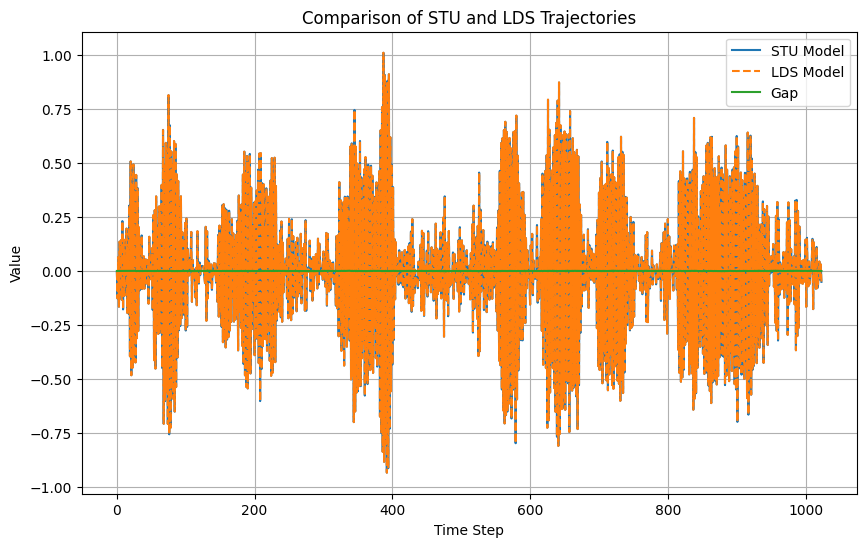

In [22]:
import matplotlib.pyplot as plt

# Generate random input and get trajectories
test_input = torch.randn(seq_len, d_in).to(device)
test_input = test_input.unsqueeze(0) # Add batch dimension

# Get STU trajectory
with torch.no_grad():
    stu_trajectory = stu_model(test_input).squeeze()

# Get LDS trajectory 
lds_trajectory = lds.reset().generate_trajectory(test_input.squeeze(0)).to(device)

gap = stu_trajectory - lds_trajectory[:, 0]
# Plot both trajectories
plt.figure(figsize=(10, 6))
plt.plot(stu_trajectory.cpu().numpy(), label='STU Model')
plt.plot(lds_trajectory.cpu().numpy(), label='LDS Model', linestyle='--')
plt.plot(gap.cpu().numpy(), label='Gap')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.title('Comparison of STU and LDS Trajectories')
plt.legend()
plt.grid(True)
plt.show()


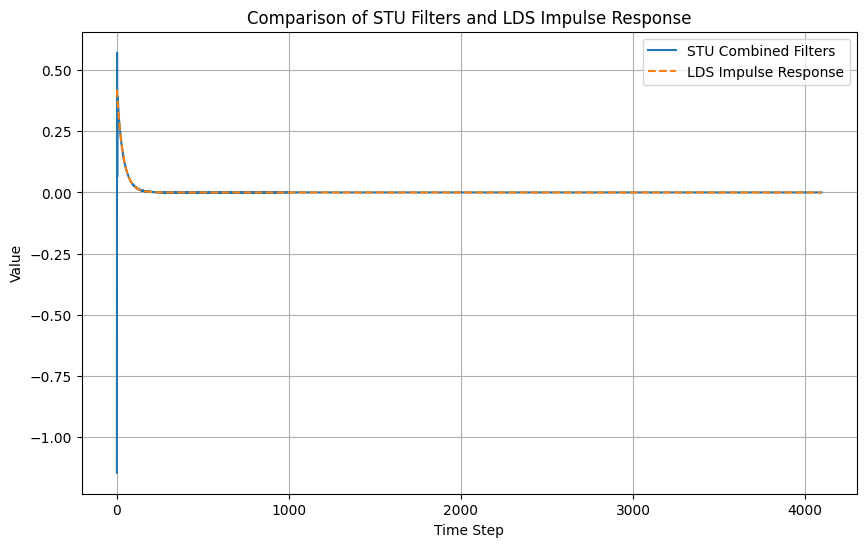

In [ ]:
# Get the STU filters and weights
filters = phi.T  # Shape: [num_filters, seq_len]
pos_weights = stu_model.M_phi_plus[:,0,0] # Shape: [1, num_filters]
neg_weights = stu_model.M_phi_minus[:,0,0] # Shape: [1, num_filters]
# Multiply each filter by its weight and sum
pos_weighted_filters = (filters.T @ pos_weights.T).squeeze()  # Shape: [seq_len]
neg_weighted_filters = (filters.T @ neg_weights.T).squeeze()  # Shape: [seq_len]

weighted_filters = pos_weighted_filters + neg_weighted_filters

# For LDS, compute the impulse response
lds_impulse = torch.zeros(seq_len)
for i in range(seq_len):
    a_power = lds.A ** i
    lds_impulse[i] = torch.sum(lds.C[:,0] * a_power * lds.B[0])

# Plot both
plt.figure(figsize=(10, 6))
plt.plot(weighted_filters.detach().cpu().numpy(), label='STU Combined Filters')
plt.plot(lds_impulse.cpu().numpy(), label='LDS Impulse Response', linestyle='--')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.title('Comparison of STU Filters and LDS Impulse Response')
plt.legend()
plt.grid(True)
plt.show()


In [167]:
import numpy as np
import tqdm

ldss = []
pos_weights_matrix = []
neg_weights_matrix = []
autoreg_weights_matrix = []
losses = []
store = []

In [168]:
for i in tqdm.tqdm(range(100)):
 
    new_lds = random_LDS(d_h = d_h, d_o = d_out, d_u = d_in, lower_bound= 0.8)  # Replace LDS with the actual class constructor if different
    
    # Fit STU to the LDS
    stu, loss = train_stu(new_lds, verbose = False)
    
    # Extract positive and negative weights
    pos_weights = stu.M_phi_plus[:, 0, 0].detach().cpu().numpy()  # Shape: [num_filters]
    neg_weights = stu.M_phi_minus[:, 0, 0].detach().cpu().numpy()  # Shape: [num_filters]
    auto_reg = stu.M.detach().cpu().numpy()
    autoreg_weights_matrix.append(auto_reg)
    
    pos_weights_matrix.append(pos_weights)
    neg_weights_matrix.append(neg_weights)
    losses.append(loss)
    store.append([new_lds, stu])

    ldss.append(new_lds)


100%|██████████| 100/100 [11:57:08<00:00, 430.28s/it]  


In [230]:
# Load the saved store data
import pickle
import glob

# Get the most recent store file
store_files = glob.glob('stu_lds_store_20250221*.pkl')
latest_store = max(store_files)

# Load the data
with open(latest_store, 'rb') as f:
    store_data = pickle.load(f)

# Reconstruct LDS and STU objects from the saved parameters
store = []
for lds_params, stu_params in store_data:
    # Create LDS with loaded parameters
    
    A = torch.tensor(lds_params['A'])
    B = torch.tensor(lds_params['B']) 
    C = torch.tensor(lds_params['C'])
    # D = torch.tensor(lds_params['D'])
    h0 = torch.tensor(lds_params['h0'])

    lds = LDS(A,B,C,D,h0)    

    # Create STU with loaded parameters
    stu = STU(stu_config, phi)
    stu.M_phi_plus.data = torch.tensor(stu_params['M_phi_plus'])
    stu.M_phi_minus.data= torch.tensor(stu_params['M_phi_minus'])
    stu.M.data = torch.tensor(stu_params['M'])

    store.append((lds, stu))

print(f"Loaded store data from {latest_store}")


Loaded store data from stu_lds_store_20250221_213044.pkl


In [242]:

def gen_lds_impulse(lds,autoreg): #need the stu for to add the negative autoregressive component
    lds_impulse = torch.zeros(seq_len)
    for i in range(stu_config["k_u"]):
        lds_impulse[i] = -1 * torch.tensor(autoreg[0][0][i])
    for i in range(seq_len):
        a_power = lds.A ** i
        lds_impulse[i] += torch.sum(lds.C[:, 0] * a_power * lds.B[0]).cpu()
    return lds_impulse

phi_n = phi.data.cpu().numpy()

def gen_stu_impulse(stu):
    alt_sign = lambda x: x * np.array([1, -1] * (seq_len//2))
    pos_coef = stu.M_phi_plus.data.cpu().numpy()[:, 0,0]
    neg_coef = stu.M_phi_minus.data.cpu().numpy()[:,0,0]
    impulse = np.sum(phi_n*pos_coef, axis = -1) + alt_sign(np.sum(phi_n*neg_coef, axis = -1))
    return impulse

In [243]:
# Get impulse responses for both LDS and STU models and store with MSE losses
pairs_with_mse = []

for lds, stu in store:
    lds_impulse = gen_lds_impulse(lds, stu.M.detach().cpu().numpy())
    stu_impulse = gen_stu_impulse(stu)
    
    # Calculate MSE between impulse responses
    mse = F.mse_loss(torch.tensor(lds_impulse)[10:], torch.tensor(stu_impulse)[10:])
    
    # Store pair with its MSE
    pairs_with_mse.append((mse, lds, stu))

# Sort by MSE and take top 40
pairs_with_mse.sort(key=lambda x: x[0])
filtered_store = [(lds, stu) for _, lds, stu in pairs_with_mse[:200]]

/var/folders/42/5cczn_jx4454n6fvhcg5qbjw0000gn/T/ipykernel_33858/54032057.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mse = F.mse_loss(torch.tensor(lds_impulse)[10:], torch.tensor(stu_impulse)[10:])


In [244]:
# Create alternating sign pattern of length 1024
alternating_signs = np.array([1, -1] * (seq_len//2))

# Multiply phi_n by alternating signs to get alternated version
phi_n_alternating = phi_n * alternating_signs[:, np.newaxis]
# Concatenate original and alternating versions along second axis
phi_n_combined = np.concatenate([phi_n, phi_n_alternating], axis=1)  # Shape: (1024, 40)


In [245]:
# For each STU, combine M_phi_plus and M_phi_minus
combined_weights = []
for _, stu in filtered_store:
    # Get M_phi_plus and M_phi_minus from STU model
    M_phi_plus = stu.M_phi_plus.detach().cpu().numpy()[:,0,0]
    M_phi_minus = stu.M_phi_minus.detach().cpu().numpy()[:,0,0]
    
    # Concatenate the weights
    combined = np.concatenate([M_phi_plus, M_phi_minus], axis=0)
    combined_weights.append(combined)

# Stack all combined weights into a single array
combined_weights = np.stack(combined_weights)
combined_weights.shape


(200, 40)

Maximum MSE between any reconstructed and original impulse pair: 3.12e-16 (at index 79)


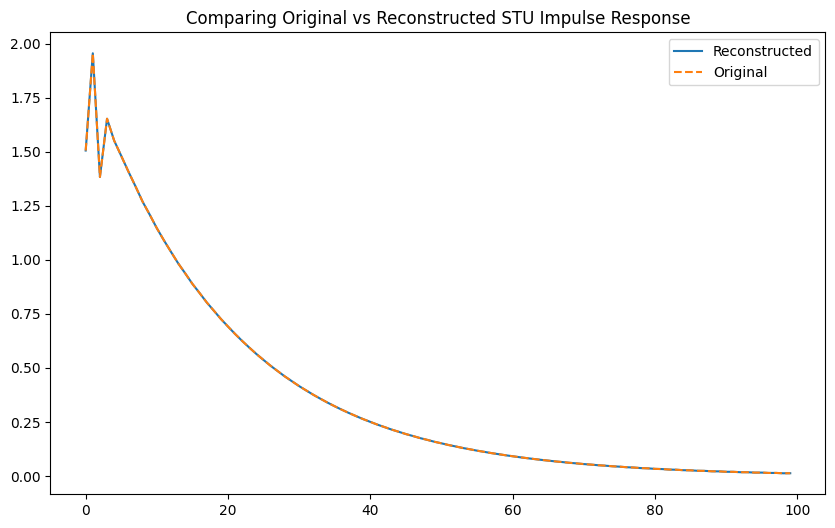

In [246]:
# Reconstruct STU filters using combined weights and phi_n_combined
reconstructed_filters = np.matmul(phi_n_combined, combined_weights.T)  # Shape: (1024, num_models)

# Get original STU impulse responses for comparison
original_impulses = []
for _, stu in filtered_store:
    impulse = gen_stu_impulse(stu)
    original_impulses.append(impulse)
original_impulses = np.stack(original_impulses).T  # Shape: (1024, num_models)

# Compare reconstructed vs original
# Calculate MSE between each pair of reconstructed and original impulses
mses = []
for i in range(reconstructed_filters.shape[1]):
    mse = F.mse_loss(torch.tensor(reconstructed_filters[:,i]), torch.tensor(original_impulses[:,i]))
    mses.append(mse.item())

max_mse = max(mses)
max_idx = mses.index(max_mse)
print(f"Maximum MSE between any reconstructed and original impulse pair: {max_mse:.2e} (at index {max_idx})")

plt.figure(figsize=(10, 6))
plt.plot(reconstructed_filters[:100,0], label='Reconstructed')
plt.plot(original_impulses[:100,0], '--', label='Original') 
plt.title('Comparing Original vs Reconstructed STU Impulse Response')
plt.legend()
plt.show()

/var/folders/42/5cczn_jx4454n6fvhcg5qbjw0000gn/T/ipykernel_33858/1789712089.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  phi_n_approx = np.matmul(torch.tensor(original_impulses), combined_weights_pinv)


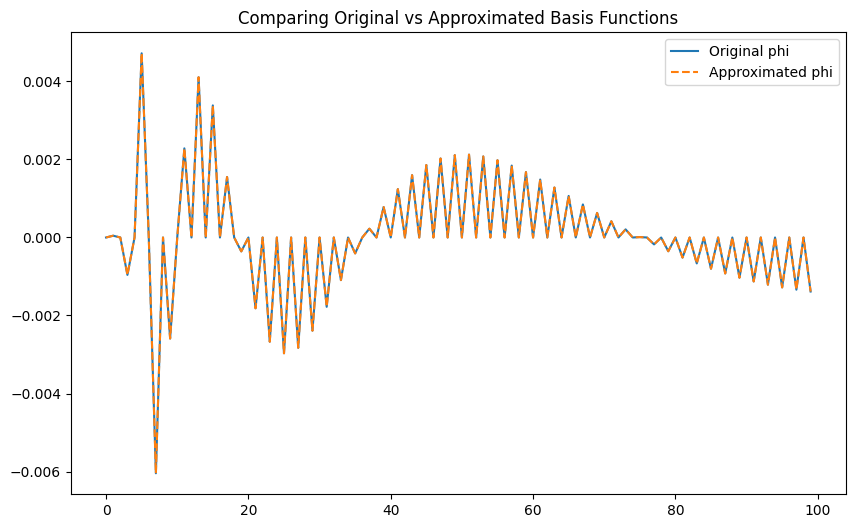

MSE between original and approximated phi: 3.90e-14


/var/folders/42/5cczn_jx4454n6fvhcg5qbjw0000gn/T/ipykernel_33858/1789712089.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mse = F.mse_loss(torch.tensor(phi_n_combined), torch.tensor(phi_n_approx))


In [247]:
# Use pseudoinverse to solve for phi_n_combined
# reconstructed_filters = phi_n_combined @ combined_weights.T
# Therefore: phi_n_combined = reconstructed_filters @ pinv(combined_weights.T)
combined_weights_pinv = np.linalg.pinv(combined_weights.T)
phi_n_approx = np.matmul(torch.tensor(original_impulses), combined_weights_pinv)

# Compare original vs approximated phi_n
plt.figure(figsize=(10, 6))
plt.plot(phi_n_combined[:100,0], label='Original phi')
plt.plot(phi_n_approx[:100,0], '--', label='Approximated phi')
plt.title('Comparing Original vs Approximated Basis Functions')
plt.legend()
plt.show()

# Calculate MSE between original and approximated phi
mse = F.mse_loss(torch.tensor(phi_n_combined), torch.tensor(phi_n_approx))
print(f"MSE between original and approximated phi: {mse:.2e}")


In [248]:
# Generate impulse responses for LDS models
lds_impulses = []
for lds, stu in filtered_store:
    impulse = gen_lds_impulse(lds, stu.M.detach().cpu().numpy())
    lds_impulses.append(impulse)
lds_impulses = np.stack(lds_impulses).T  # Shape: (seq_len, num_models)


In [249]:
# simulating adding 10 autoregressive terms
lds_impulses[:10, :] = original_impulses[:10, :]

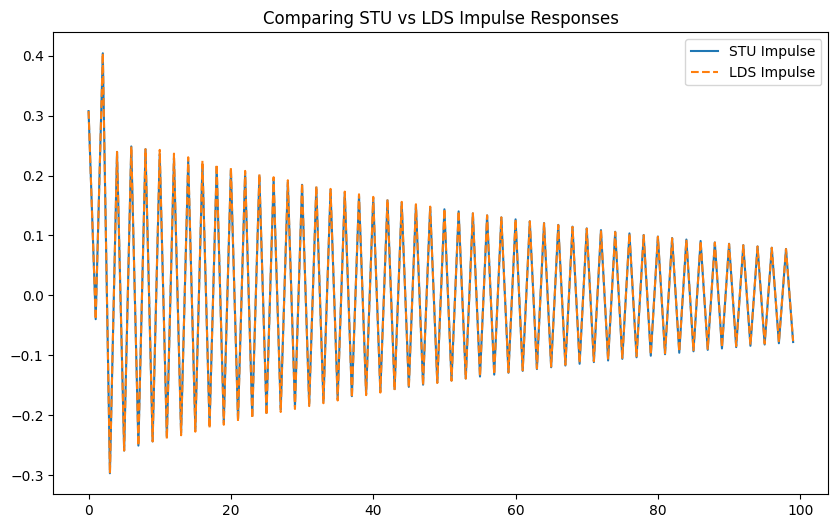

MSE between STU and LDS impulse 0: 2.41e-07
MSE between STU and LDS impulse 1: 3.30e-07
MSE between STU and LDS impulse 2: 3.34e-07
MSE between STU and LDS impulse 3: 3.59e-07
MSE between STU and LDS impulse 4: 4.02e-07
MSE between STU and LDS impulse 5: 4.02e-07
MSE between STU and LDS impulse 6: 4.16e-07
MSE between STU and LDS impulse 7: 4.27e-07
MSE between STU and LDS impulse 8: 4.27e-07
MSE between STU and LDS impulse 9: 4.29e-07
MSE between STU and LDS impulse 10: 4.52e-07
MSE between STU and LDS impulse 11: 5.03e-07
MSE between STU and LDS impulse 12: 5.04e-07
MSE between STU and LDS impulse 13: 5.09e-07
MSE between STU and LDS impulse 14: 5.40e-07
MSE between STU and LDS impulse 15: 5.41e-07
MSE between STU and LDS impulse 16: 5.49e-07
MSE between STU and LDS impulse 17: 5.59e-07
MSE between STU and LDS impulse 18: 5.91e-07
MSE between STU and LDS impulse 19: 6.01e-07
MSE between STU and LDS impulse 20: 6.07e-07
MSE between STU and LDS impulse 21: 6.08e-07
MSE between STU and 

In [250]:
# Compare original STU impulses with LDS impulses
plt.figure(figsize=(10, 6))
plt.plot(original_impulses[:100,31], label='STU Impulse')
plt.plot(lds_impulses[:100,31], '--', label='LDS Impulse')
plt.title('Comparing STU vs LDS Impulse Responses')
plt.legend()
plt.show()

# Calculate MSE between STU and LDS impulses
for i in range(40):
    mse = F.mse_loss(torch.tensor(lds_impulses[:, i]), torch.tensor(original_impulses[:, i]))
    print(f"MSE between STU and LDS impulse {i}: {mse:.2e}")


In [251]:
combined_weights_pinv

array([[-0.10291825, -0.47473985, -0.03692134, ..., -0.00610533,
        -0.00633237, -0.01014481],
       [-0.09574682,  0.0095944 ,  0.28872222, ...,  0.03913923,
        -0.01116522,  0.06707414],
       [ 0.12692484, -0.18615276,  0.04137774, ..., -0.0983032 ,
        -0.04910852, -0.10121937],
       ...,
       [-0.09755644, -0.38175115,  0.45138425, ..., -0.06497262,
        -0.01256189, -0.02363953],
       [-0.0996928 ,  0.07396061,  0.25098136, ...,  0.01230924,
         0.00822431,  0.0212073 ],
       [ 0.02100625,  0.2806677 , -0.12713566, ..., -0.05006972,
        -0.04759369,  0.05760705]], shape=(200, 40), dtype=float32)

/var/folders/42/5cczn_jx4454n6fvhcg5qbjw0000gn/T/ipykernel_33858/2629277523.py:2: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  phi_n_approx = np.matmul(torch.tensor(lds_impulses), combined_weights_pinv)


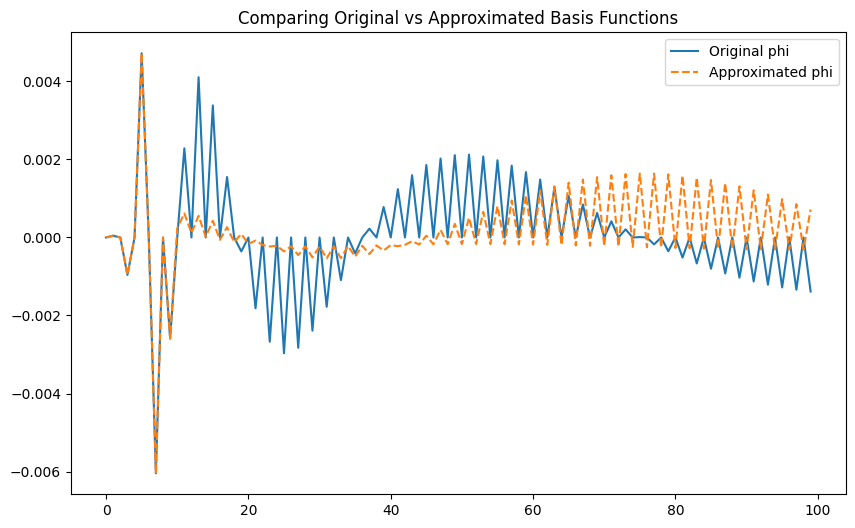

MSE between original and approximated phi: 2.26e-05


/var/folders/42/5cczn_jx4454n6fvhcg5qbjw0000gn/T/ipykernel_33858/2629277523.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mse = F.mse_loss(torch.tensor(phi_n_combined), torch.tensor(phi_n_approx))


In [252]:
combined_weights_pinv = np.linalg.pinv(combined_weights.T)
phi_n_approx = np.matmul(torch.tensor(lds_impulses), combined_weights_pinv)

# Compare original vs approximated phi_n
plt.figure(figsize=(10, 6))
plt.plot(phi_n_combined[:100,0], label='Original phi')
plt.plot(phi_n_approx[:100,0], '--', label='Approximated phi')
plt.title('Comparing Original vs Approximated Basis Functions')
plt.legend()
plt.show()

# Calculate MSE between original and approximated phi
mse = F.mse_loss(torch.tensor(phi_n_combined), torch.tensor(phi_n_approx))
print(f"MSE between original and approximated phi: {mse:.2e}")


In [255]:
combined_weights_pinv = np.linalg.pinv(combined_weights.T)
combined_weights_pinv = torch.tensor(combined_weights_pinv, requires_grad=True).to(torch.float)
lds_impulses_tensor = torch.tensor(lds_impulses)
phi_n_combined_tensor = torch.tensor(phi_n_combined).to(torch.float)

# Gradient descent to refine the weights
optimizer = torch.optim.Adam([combined_weights_pinv], lr=1e-5)

for i in range(5000000):
    optimizer.zero_grad()
    
    # Forward pass
    phi_n_approx = torch.matmul(lds_impulses_tensor, combined_weights_pinv)
    
    # Calculate loss focusing on first column
    loss = F.mse_loss(phi_n_approx[:,0], phi_n_combined_tensor[:,0])
    
    # Backward pass
    loss.backward()
    optimizer.step()
    
    if i % 5000 == 0:
        print(f"Iteration {i}, Loss: {loss.item():.2e}")

# Convert back to numpy for plotting
phi_n_approx = torch.matmul(lds_impulses_tensor, combined_weights_pinv).detach()

# Compare original vs approximated phi_n
plt.figure(figsize=(10, 6))
plt.plot(phi_n_combined[:100,0], label='Original phi')
plt.plot(phi_n_approx[:100,0], '--', label='Approximated phi')
plt.title('Comparing Original vs Approximated Basis Functions')
plt.legend()
plt.show()

# Calculate MSE between original and approximated phi
mse = F.mse_loss(phi_n_combined_tensor, phi_n_approx)
print(f"MSE between original and approximated phi: {mse:.2e}")


Iteration 0, Loss: 2.11e-06
Iteration 5000, Loss: 1.38e-06
Iteration 10000, Loss: 1.03e-06
Iteration 15000, Loss: 8.42e-07
Iteration 20000, Loss: 7.25e-07
Iteration 25000, Loss: 6.37e-07
Iteration 30000, Loss: 5.64e-07
Iteration 35000, Loss: 5.00e-07
Iteration 40000, Loss: 4.45e-07
Iteration 45000, Loss: 3.98e-07
Iteration 50000, Loss: 3.57e-07
Iteration 55000, Loss: 3.23e-07
Iteration 60000, Loss: 2.94e-07
Iteration 65000, Loss: 2.70e-07
Iteration 70000, Loss: 2.51e-07
Iteration 75000, Loss: 2.36e-07
Iteration 80000, Loss: 2.23e-07
Iteration 85000, Loss: 2.14e-07
Iteration 90000, Loss: 2.06e-07
Iteration 95000, Loss: 1.99e-07
Iteration 100000, Loss: 1.93e-07
Iteration 105000, Loss: 1.88e-07
Iteration 110000, Loss: 1.84e-07
Iteration 115000, Loss: 1.80e-07
Iteration 120000, Loss: 1.76e-07
Iteration 125000, Loss: 1.72e-07
Iteration 130000, Loss: 1.69e-07
Iteration 135000, Loss: 1.65e-07
Iteration 140000, Loss: 1.62e-07
Iteration 145000, Loss: 1.59e-07
Iteration 150000, Loss: 1.57e-07
It

KeyboardInterrupt: 

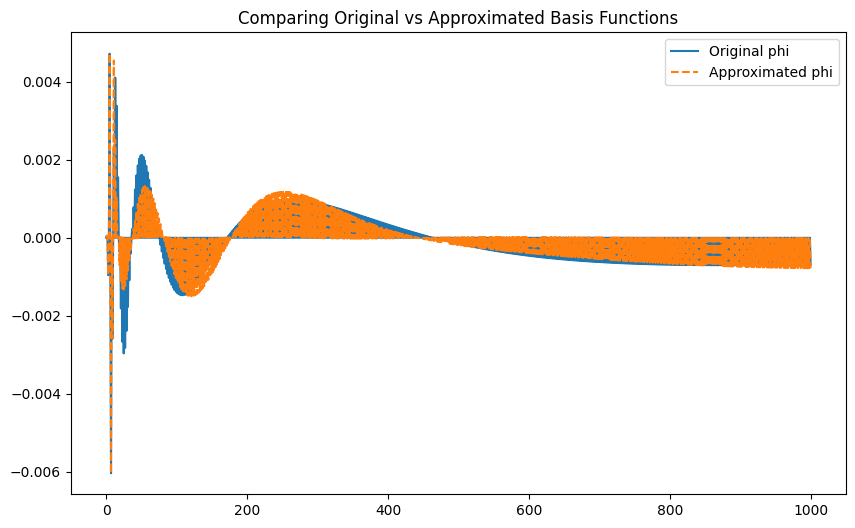

MSE between original and approximated phi: 2.25e-05


In [259]:
# Convert back to numpy for plotting
phi_n_approx = torch.matmul(lds_impulses_tensor, combined_weights_pinv).detach()

# Compare original vs approximated phi_n
plt.figure(figsize=(10, 6))
plt.plot(phi_n_combined[:1000,0], label='Original phi')
plt.plot(phi_n_approx[:1000,0], '--', label='Approximated phi')
plt.title('Comparing Original vs Approximated Basis Functions')
plt.legend()
plt.show()

# Calculate MSE between original and approximated phi
mse = F.mse_loss(phi_n_combined_tensor, phi_n_approx)
print(f"MSE between original and approximated phi: {mse:.2e}")

In [265]:
# Save the learned filter (first basis function)
recon_phi_0 = phi_n_approx[:,0].detach().numpy()
np.save('recon_phi_0.npy', recon_phi_0)

# Save the LDS parameters
for i, (lds, stu) in enumerate(filtered_store):
    # Save individual LDS parameters
    np.savez(f'recon_lds_{i}.npz',
             A=lds.A.detach().numpy(),
             B=lds.B.detach().numpy(), 
             C=lds.C.detach().numpy(),
             D=lds.D.detach().numpy(),
             h0=lds.h0.detach().numpy())

# Save the reconstruction weights
np.save('recon_combined_weights_pinv.npy', combined_weights_pinv.detach().numpy())

print("Saved reconstruction data:")
print(f"Filter shape: {recon_phi_0.shape}")
print(f"Number of LDS models saved: {len(filtered_store)}")
print(f"Combined weights shape: {combined_weights_pinv.shape}")


Saved reconstruction data:
Filter shape: (1024,)
Number of LDS models saved: 200
Combined weights shape: torch.Size([200, 40])
